In [71]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
words = open('names.txt', 'r').read().splitlines()

In [5]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [6]:
len(words)

32033

In [7]:
min(len(w) for w in words)

2

In [8]:
max(len(w) for w in words)

15

In [9]:
# b = {}
# for w in words:
#     chs = ['<E>'] + list(w) + ['<E>']
#     for ch1, ch2 in zip(chs, chs[1:]):
#         bigram = (ch1, ch2)
#         b[bigram] = b.get(bigram, 0) + 1
# sorted(b.items(), key = lambda kv: -kv[1])

In [13]:
N = torch.zeros((27, 27), dtype = torch.int32)

In [14]:
chars = sorted(list(set(''.join(words))))
chars = chars + ['<E>']
stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()}

In [15]:
for w in words:
    chs = ['<E>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

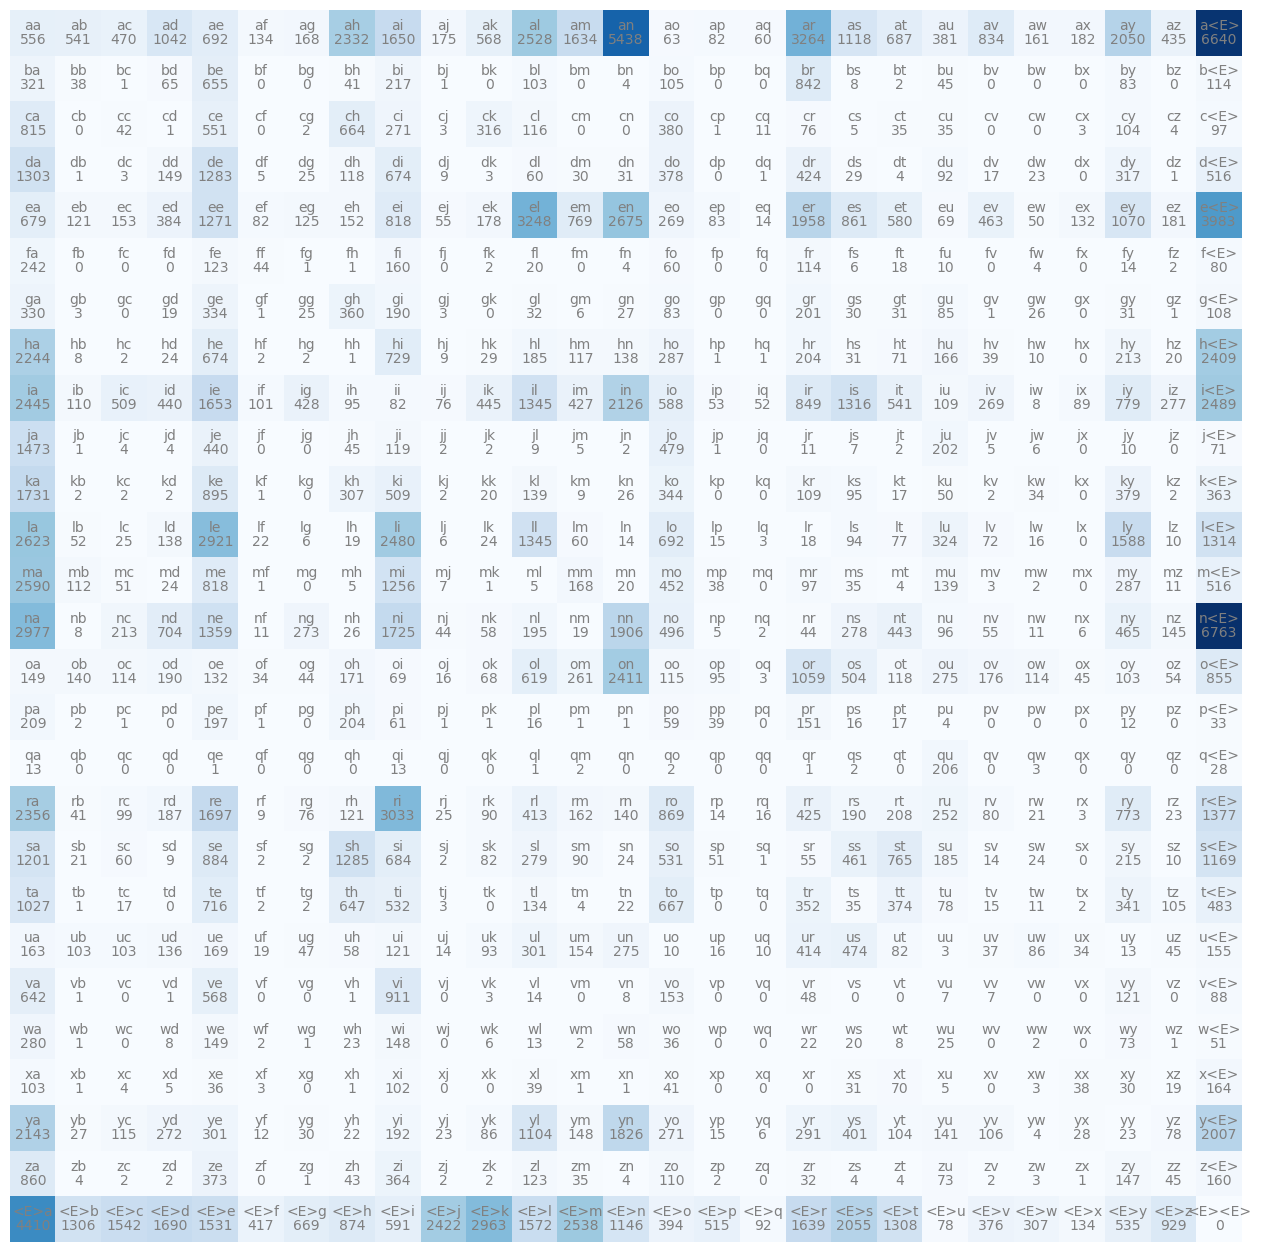

In [16]:
plt.figure(figsize = (16, 16))
plt.imshow(N, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = 'center', va = 'bottom', color = 'gray')
        plt.text(j, i, N[i, j].item(), ha = 'center', va = 'top', color = 'gray')
plt.axis('off');

In [64]:
P = (N + 1).float() #To smoothen probabilities and to prevent inf loss 1 is added
P = P.divide(P.sum(1, keepdim = True))

In [65]:
g = torch.Generator().manual_seed(42)
ix = 26
for i in range(5):
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 26:
            break
    print(''.join(out))

zayte<E>
rinariraemycllin<E>
khasera<E>
sh<E>
reydixon<E>


In [66]:
# g = torch.Generator().manual_seed(42)
# p = torch.rand(3, generator = g)
# p = p / p.sum()
# torch.multinomial(p, num_samples = 20, replacement = True, generator = g)

In [380]:
log_likelihood = 0.0
cnt = 0
for w in words:
    chs = ['<E>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        prob = P[stoi[ch1], stoi[ch2]]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        cnt += 1
#         print(f"({ch1}, {ch2}) : {prob:.4f}, {log_prob:.4f}")
print(f"{-log_likelihood=}")
nll = -log_likelihood 
print(f"{nll/cnt}")

-log_likelihood=tensor(559951.5625)
2.4543561935424805


***Neural Net for Bigrams***

In [346]:
#Creating the training set
xs, ys = [], []
for w in words:
    chs = ['<E>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
#         print(ch1, ch2)
        
        xs.append(ix1)
        ys.append(ix2)
        
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

print(f"Num examples: {num}")

#Initializing the network
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), generator = g, requires_grad = True)

Num examples: 228146


In [381]:
for k in range(10):
    
    #Forward Pass
    x_onehot = F.one_hot(xs, num_classes = 27).float()
    logits = x_onehot @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim = True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())
    
    #backward pass
    W.grad = None
    loss.backward()
    
    #Update weights
    W.data += -50 * W.grad

2.481297254562378
2.4812912940979004
2.481285333633423
2.4812798500061035
2.481273889541626
2.4812684059143066
2.481262683868408
2.481257200241089
2.4812514781951904
2.481245994567871


In [359]:
# nlls = torch.zeros(5)
# for i in range(5):
#     x = xs[i].item()
#     y = ys[i].item()
#     p = probs[i, y]
#     logp = torch.log(p)
#     nll = -logp
#     nlls[i] = nll
# nlls.mean().item()

In [386]:
g = torch.Generator().manual_seed(42)
for i in range(5):
    word = []
    ix = 26
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        logits = x_enc @ W
        
        counts = logits.exp().reshape(1, 27)
        probs = counts / counts.sum(1, keepdim = True)
        ix = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
    
        word.append(itos[ix])
        if ix == 26:
            break;
        
    print(''.join(word))

zayte<E>
rinariraemycllin<E>
khasera<E>
sh<E>
reydixon<E>
